In [71]:
%%capture

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

from model import RNNBaseModel
from train import RNNTrainer

%run etl_feature.ipynb
%run etl_load.ipynb

### Index Normalizing

In [72]:
def upsample_to_hourly(df):
    if pd.infer_freq(df.index) == 'D':
        return df.resample('H').ffill() 
    return df

df_weather = upsample_to_hourly(df_weather)
df_cloud = upsample_to_hourly(df_cloud)

/var/folders/fx/vf6fk88550923hfq9c5dw5pm0000gn/T/ipykernel_4143/2070566789.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.resample('H').ffill()


### Modeling ERCOT Solar Generation

In [73]:
df_solar_features = df_solar[["ERCOT.PVGR.GEN", "Total Solar Installed, MW", "Solar 1-hr MW change", "Solar 1-hr % change"]]
df_weather_features = df_weather[["tavg", "tmin", "tmax", "prcp", "snow"]]
df_cloud_features = df_cloud["Cloud Coverage"]

df_solar_features = df_solar_features[~df_solar_features.index.duplicated(keep='first')]
df_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]
df_cloud_features = df_cloud_features[~df_cloud_features.index.duplicated(keep='first')]

df = pd.concat([df_solar_features, df_weather_features, df_cloud_features], axis=1, join="inner")
df.fillna(0) #NA created from ramps 
df = df.dropna()  # BEFORE scaling


In [74]:
df = df.sort_index()

target_col = "ERCOT.PVGR.GEN"
features = df.drop(columns=[target_col])
target = df[[target_col]]  

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)

# Create sequences
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24  # Use 24 hours of data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Train/test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [75]:
batch_size = 32

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.float32))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.float32))
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [76]:


class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)

input_size = X_train.shape[2]  # number of features
model = RNNModel(input_size=input_size, hidden_size=64)


In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dl):.4f}")


Epoch 1, Loss: 0.4067
Epoch 2, Loss: 0.0967
Epoch 3, Loss: 0.0636
Epoch 4, Loss: 0.0500
Epoch 5, Loss: 0.0429
Epoch 6, Loss: 0.0383
Epoch 7, Loss: 0.0352
Epoch 8, Loss: 0.0332
Epoch 9, Loss: 0.0315
Epoch 10, Loss: 0.0302
Epoch 11, Loss: 0.0293
Epoch 12, Loss: 0.0284
Epoch 13, Loss: 0.0277
Epoch 14, Loss: 0.0271
Epoch 15, Loss: 0.0265
Epoch 16, Loss: 0.0256
Epoch 17, Loss: 0.0254
Epoch 18, Loss: 0.0245
Epoch 19, Loss: 0.0240
Epoch 20, Loss: 0.0235


In [78]:
model.eval()
with torch.no_grad():
    preds = []
    for xb, _ in test_dl:
        out = model(xb).numpy()
        preds.append(out)
    preds = np.vstack(preds)

# Inverse transform
preds_real = scaler_y.inverse_transform(preds)
y_test_real = scaler_y.inverse_transform(y_test)


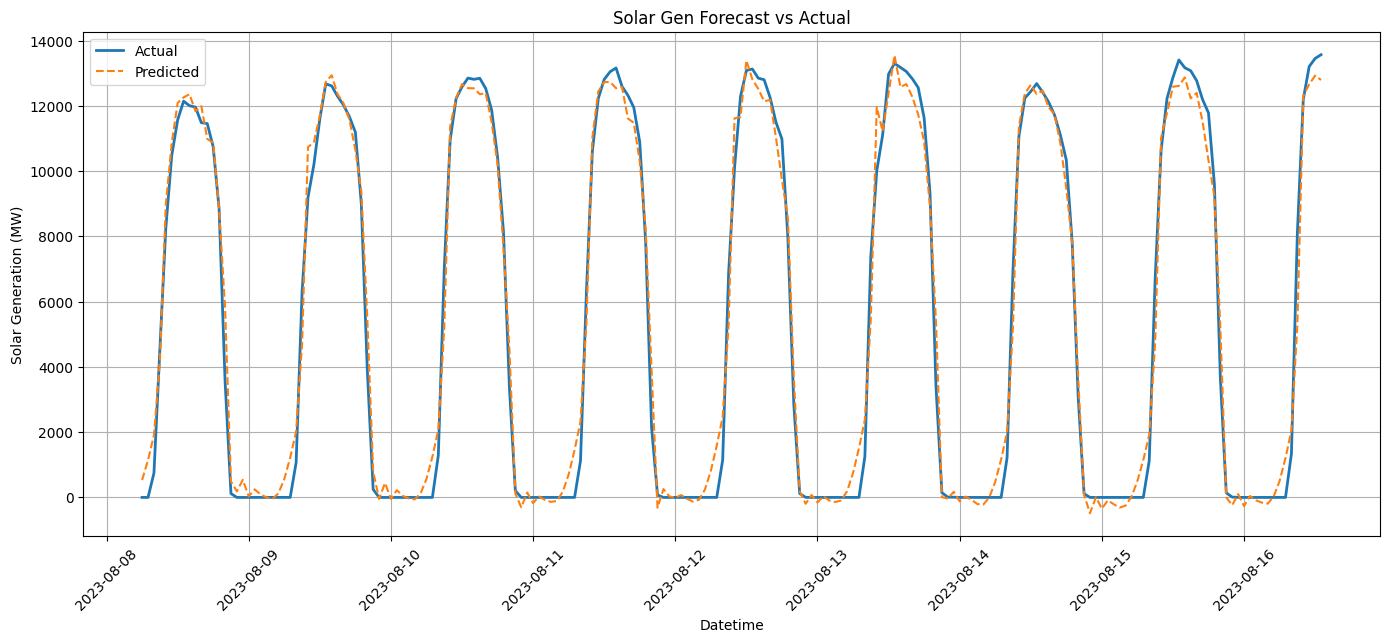

In [79]:
test_index = df.index[window_size + split : window_size + split + len(y_test_real)]

# Plot
n_plot = 200  # how many to show
plt.figure(figsize=(14, 6))
plt.plot(test_index[:n_plot], y_test_real[:n_plot], label="Actual", linewidth=2)
plt.plot(test_index[:n_plot], preds_real[:n_plot], label="Predicted", linestyle="--")
plt.title("Solar Gen Forecast vs Actual")
plt.xlabel("Datetime")
plt.ylabel("Solar Generation (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


### Modeling Wind Generation

In [80]:
df_wind_features = df_wind[["ERCOT.WIND.GEN", "Total Wind Installed, MW", "Wind 1-hr MW change", "Wind 1-hr % change"]]
df_wind_weather_features = df_weather[["snow", "wdir", "wspd", "pres"]]

df_wind_features = df_wind_features[~df_wind_features.index.duplicated(keep='first')]
df_wind_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]

df = pd.concat([df_wind_features, df_weather_features], axis=1, join="inner")
df.fillna(0) #NA created from ramps 
df = df.dropna()  # BEFORE scaling

In [81]:
df = df.sort_index()

target_col = "ERCOT.WIND.GEN"
features = df.drop(columns=[target_col])
target = df[[target_col]]  

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)

# Create sequences
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24  # Use 24 hours of data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Train/test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [82]:
batch_size = 32

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.float32))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.float32))
test_dl = DataLoader(test_ds, batch_size=batch_size)

input_size = X_train.shape[2]  # number of features
model = RNNModel(input_size=input_size, hidden_size=64)

In [83]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dl):.4f}")


Epoch 1, Loss: 0.7790
Epoch 2, Loss: 0.5085
Epoch 3, Loss: 0.3490
Epoch 4, Loss: 0.2040
Epoch 5, Loss: 0.1577
Epoch 6, Loss: 0.1329
Epoch 7, Loss: 0.1119
Epoch 8, Loss: 0.0966
Epoch 9, Loss: 0.0828
Epoch 10, Loss: 0.0735
Epoch 11, Loss: 0.0660
Epoch 12, Loss: 0.0592
Epoch 13, Loss: 0.0542
Epoch 14, Loss: 0.0495
Epoch 15, Loss: 0.0478
Epoch 16, Loss: 0.0442
Epoch 17, Loss: 0.0417
Epoch 18, Loss: 0.0392
Epoch 19, Loss: 0.0376
Epoch 20, Loss: 0.0358


In [84]:
model.eval()
with torch.no_grad():
    preds = []
    for xb, _ in test_dl:
        out = model(xb).numpy()
        preds.append(out)
    preds = np.vstack(preds)

# Inverse transform
preds_real = scaler_y.inverse_transform(preds)
y_test_real = scaler_y.inverse_transform(y_test)


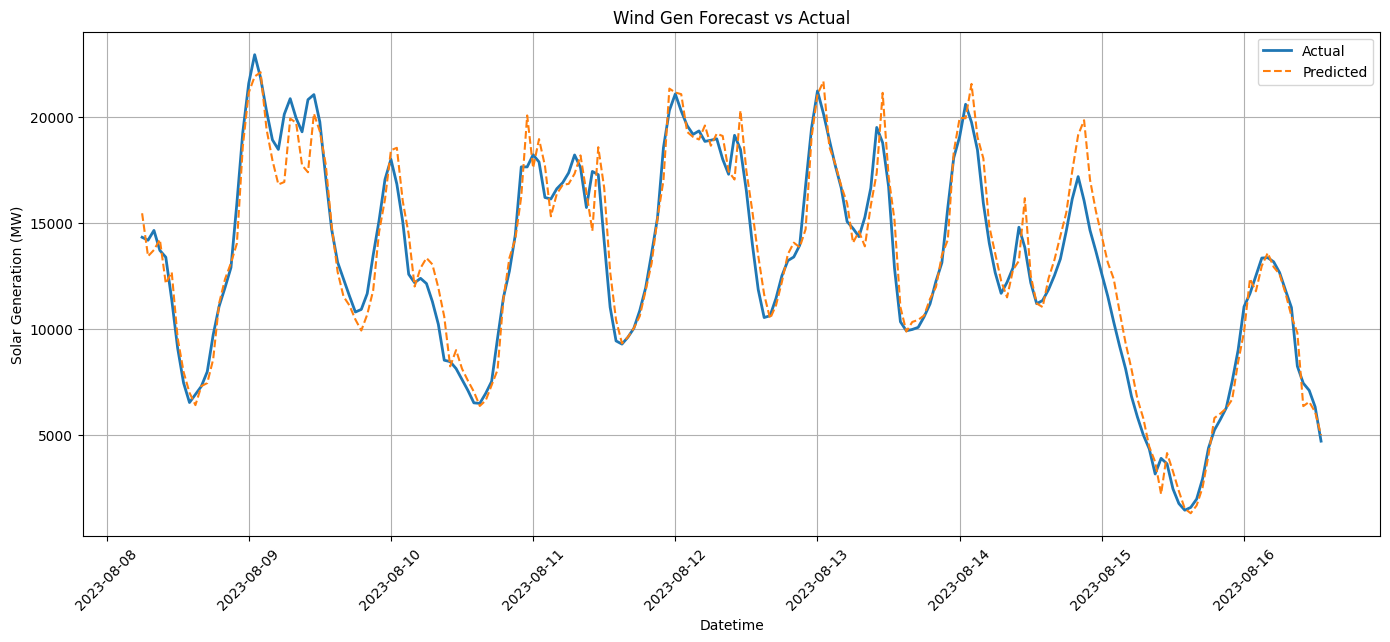

In [85]:
test_index = df.index[window_size + split : window_size + split + len(y_test_real)]

# Plot
n_plot = 200  # how many to show
plt.figure(figsize=(14, 6))
plt.plot(test_index[:n_plot], y_test_real[:n_plot], label="Actual", linewidth=2)
plt.plot(test_index[:n_plot], preds_real[:n_plot], label="Predicted", linestyle="--")
plt.title("Wind Gen Forecast vs Actual")
plt.xlabel("Datetime")
plt.ylabel("Solar Generation (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


### Load forecasting

In [86]:
df_load_features = df_load[["ERCOT"]]
df_weather_features = df_weather[["tavg", "tmin", "tmax", "prcp", "wdir", "wspd"]]

df_load_features = df_load_features[~df_load_features.index.duplicated(keep='first')]
df_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]

df = pd.concat([df_load_features, df_weather_features], axis=1, join="inner")
df.fillna(0) #NA created from ramps 
df = df.dropna()  # BEFORE scaling
df

,ERCOT,tavg,tmin,tmax,prcp,wdir,wspd
2022-01-01 01:00:00,38006.938896,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 02:00:00,37036.522365,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 03:00:00,35881.607998,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 04:00:00,35044.055105,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 05:00:00,34585.571140,16.06,2.91,22.18,0.66,272.3,22.24
...,...,...,...,...,...,...,...
2023-12-28 00:00:00,46472.957947,7.07,1.16,12.88,0.00,279.4,12.24
2023-12-29 00:00:00,47912.210531,6.55,0.44,14.69,0.00,247.5,12.76
2023-12-30 00:00:00,47741.831804,8.62,0.46,18.83,0.00,244.1,7.99
2023-12-31 00:00:00,44742.203232,10.94,3.55,18.94,0.00,172.1,10.87


In [87]:
df = df.sort_index()

target_col = "ERCOT"
features = df.drop(columns=[target_col])
target = df[[target_col]]  

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)

# Create sequences
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24  # Use 24 hours of data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Train/test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

Epoch 1/20 | Train Loss: 0.4663 | Val Loss: 0.5054
Epoch 2/20 | Train Loss: 0.4169 | Val Loss: 0.4710
Epoch 3/20 | Train Loss: 0.4112 | Val Loss: 0.4680
Epoch 4/20 | Train Loss: 0.4068 | Val Loss: 0.4729
Epoch 5/20 | Train Loss: 0.3907 | Val Loss: 0.4169
Epoch 6/20 | Train Loss: 0.3523 | Val Loss: 0.3982
Epoch 7/20 | Train Loss: 0.2675 | Val Loss: 0.2632
Epoch 8/20 | Train Loss: 0.2084 | Val Loss: 0.2071
Epoch 9/20 | Train Loss: 0.1739 | Val Loss: 0.2297
Epoch 10/20 | Train Loss: 0.1489 | Val Loss: 0.1603
Epoch 11/20 | Train Loss: 0.1303 | Val Loss: 0.2004
Epoch 12/20 | Train Loss: 0.1151 | Val Loss: 0.1302
Epoch 13/20 | Train Loss: 0.1122 | Val Loss: 0.2010
Epoch 14/20 | Train Loss: 0.1121 | Val Loss: 0.1386
Epoch 15/20 | Train Loss: 0.0983 | Val Loss: 0.1277
Epoch 16/20 | Train Loss: 0.0915 | Val Loss: 0.1349
Epoch 17/20 | Train Loss: 0.0910 | Val Loss: 0.1835
Epoch 18/20 | Train Loss: 0.0874 | Val Loss: 0.1435
Epoch 19/20 | Train Loss: 0.0810 | Val Loss: 0.1658
Epoch 20/20 | Train L

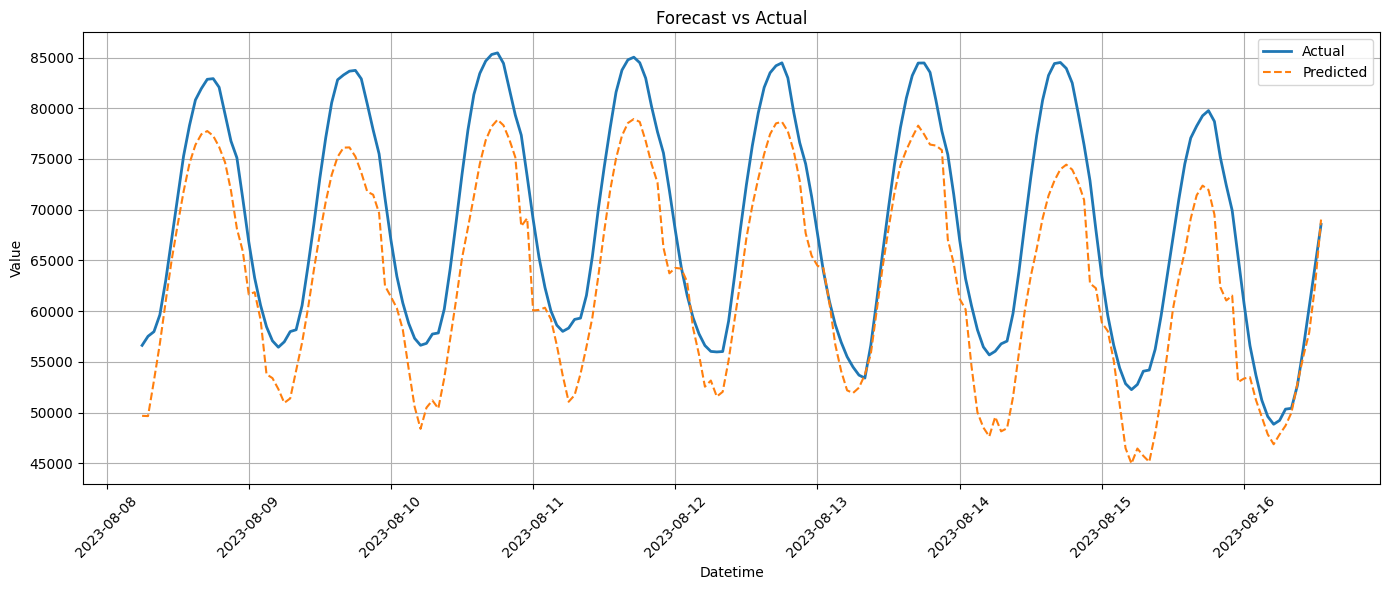

In [89]:
# 1. Build model
model = RNNBaseModel(input_size=X_train.shape[2], hidden_size=64)

# 2. Initialize trainer
trainer = RNNTrainer(model)

# 3. Train
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20)

# 4. Setup datetime index for plotting
test_index = df.index[window_size + split : window_size + split + len(y_test)]

# 5. Plot
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)
